In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.10.0
Eager execution: True


In [2]:
DATA_DIR = "./hub_dataset"
BOTTLE_DIR = "./bottleneck"
TRAIN_DIR = DATA_DIR + "/train"
VAL_DIR = DATA_DIR + "/validation"
file_tail = "_https~tfhub.dev~google~imagenet~pnasnet_large~feature_vector~1.txt"

In [3]:
import glob

NUM_TRAIN_EXAMPLES = 0
NUM_VAL_EXAMPLES = 0

if not os.path.exists(TRAIN_DIR) or  not os.path.exists(VAL_DIR):
    data = glob.glob(BOTTLE_DIR + "/*/*.txt")
    print("creating data directories for training and validation")
    train, val = model_selection.train_test_split(data, test_size=0.1)
    os.makedirs(TRAIN_DIR)
    os.makedirs(VAL_DIR)

    for e in train:
        shutil.copy(e, TRAIN_DIR + "/" + e.split("/")[-1] )
    for e in val:
        shutil.copy(e, VAL_DIR + "/" + e.split("/")[-1] )
else:
    print("directories already exist")
    NUM_TRAIN_EXAMPLES = len(glob.glob(TRAIN_DIR+"/*.txt"))
    print("Train:", NUM_TRAIN_EXAMPLES )
    NUM_VAL_EXAMPLES = len(glob.glob(VAL_DIR+"/*.txt"))
    print("Validation:",NUM_VAL_EXAMPLES )

directories already exist
Train: 145134
Validation: 16126


In [4]:
import numpy as np

with np.load('./mvc_train_kor.npz') as train_data:
    x_train = train_data['x_train']
    y_train = train_data['y_train']    


In [5]:
with np.load('./mvc_valid_kor.npz') as test_data:
    x_val = test_data['x_val']
    y_val = test_data['y_val']

In [6]:
print("Validation examples:", len(x_val))
print("Y val examples:", len(y_val))
print("Train examples:", len(x_train))
print("Y examples:", len(y_train))

Validation examples: 16126
Y val examples: 16126
Train examples: 145134
Y examples: 145134


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(2048, activation=tf.nn.relu, input_shape=(x_train.shape[1],)),  # input shape required
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),    
    tf.keras.layers.Dense(y_train.shape[1]),
])

In [8]:
def loss(model, x, y):
    y_ = model(x)
    batch=tf.size(x, out_type=tf.int64)
    
    weight = 1-tf.divide(tf.reduce_sum(y,0, keepdims=True),batch)
    #return weight
    #weighted_y = weight*tf.cast(y, tf.float64)
    #output = tf.cast(tf.log(y_), tf.float64)
    #return -weighted_y*output
    return tf.nn.weighted_cross_entropy_with_logits(targets=tf.cast(y, tf.float32), logits=y_, pos_weight=tf.cast(weight, tf.float32))

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [10]:
train_dataset = train_dataset.batch(1024)
train_dataset

<BatchDataset shapes: ((?, 4320), (?, 187)), types: (tf.float32, tf.int64)>

In [11]:
features, labels = next(iter(train_dataset))
print(features[:5])

tf.Tensor(
[[ 0.          0.          0.         ...,  0.0977826   0.48774499
   0.00196367]
 [ 0.          0.          0.         ...,  0.17316701  0.          0.0287158 ]
 [ 0.          0.          0.         ...,  0.          0.04606     0.        ]
 [ 0.          0.00384228  0.         ...,  0.119532    0.47446099  0.        ]
 [ 0.          0.          0.00071149 ...,  0.177524    0.27370301
   0.0604458 ]], shape=(5, 4320), dtype=float32)


In [12]:
l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: [[ 0.59163189  0.71097738  0.57429487 ...,  0.65939319  0.7114706
   0.67783958]
 [ 0.56265879  0.68648064  0.62064207 ...,  0.74751979  0.71614057
   0.59764254]
 [ 0.57492566  0.63999861  0.5895673  ...,  0.70498395  0.63569546
   0.69647205]
 ..., 
 [ 0.55588794  0.68498254  0.65219504 ...,  0.65347707  0.68948239
   0.76821017]
 [ 0.4975872   0.71909553  0.63839352 ...,  0.68672472  0.68237913
   0.71813607]
 [ 0.55114907  0.80960429  0.69429386 ...,  0.73461056  0.67096347
   0.8051039 ]]


In [13]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [14]:
optimizer = tf.train.AdamOptimizer()
global_step = tf.contrib.eager.Variable(0)


In [15]:
from tensorflow import contrib
tfe = contrib.eager

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 20W

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.BinaryAccuracy(threshold=0.5)
    
    # Training loop - using batches of 32
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables),
                                  global_step)

        # Track progress
        epoch_loss_avg(loss_value)  # add current batch loss
        # compare predicted label to actual label


       
        epoch_accuracy(tf.cast(y,tf.bool), model(x))

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())


    print("Epoch {:02d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                            epoch_loss_avg.result(),
                                                            epoch_accuracy.result()))    

Epoch 00: Loss: 0.062, Accuracy: 98.281%
Epoch 01: Loss: 0.040, Accuracy: 98.502%
Epoch 02: Loss: 0.038, Accuracy: 98.583%
Epoch 03: Loss: 0.036, Accuracy: 98.640%
Epoch 04: Loss: 0.034, Accuracy: 98.687%
Epoch 05: Loss: 0.033, Accuracy: 98.727%
Epoch 06: Loss: 0.032, Accuracy: 98.763%
Epoch 07: Loss: 0.031, Accuracy: 98.796%
Epoch 08: Loss: 0.030, Accuracy: 98.830%
Epoch 09: Loss: 0.029, Accuracy: 98.862%
Epoch 10: Loss: 0.028, Accuracy: 98.894%
Epoch 11: Loss: 0.027, Accuracy: 98.926%
Epoch 12: Loss: 0.026, Accuracy: 98.959%
Epoch 13: Loss: 0.025, Accuracy: 98.991%
Epoch 14: Loss: 0.025, Accuracy: 99.023%
Epoch 15: Loss: 0.024, Accuracy: 99.056%
Epoch 16: Loss: 0.023, Accuracy: 99.087%
Epoch 17: Loss: 0.022, Accuracy: 99.117%
Epoch 18: Loss: 0.022, Accuracy: 99.139%
Epoch 19: Loss: 0.021, Accuracy: 99.151%
Epoch 20: Loss: 0.021, Accuracy: 99.168%


KeyboardInterrupt: 

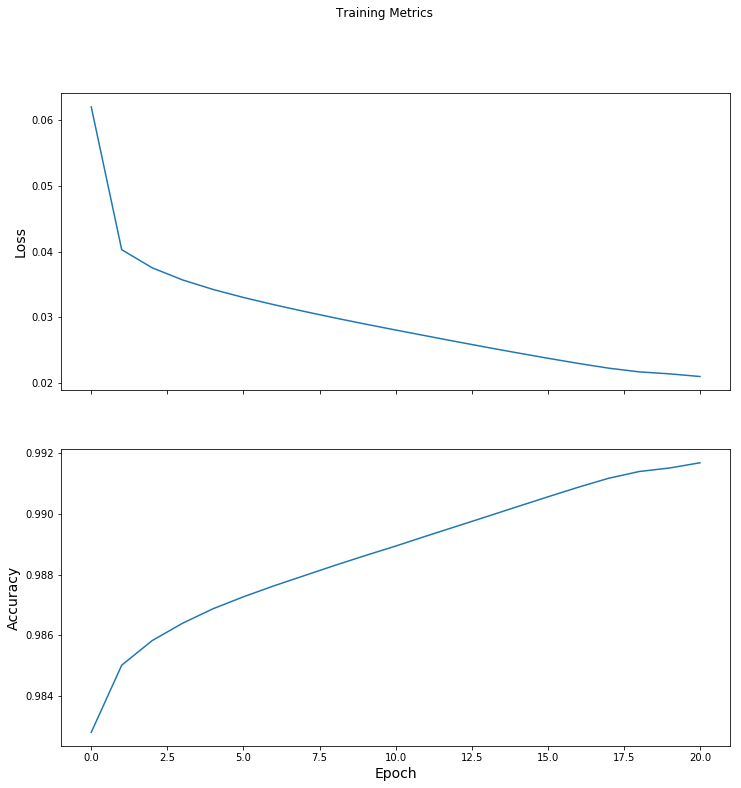

In [16]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 12))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results);

In [17]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [18]:
test_dataset = test_dataset.batch(16126)
test_dataset

<BatchDataset shapes: ((?, 4320), (?, 187)), types: (tf.float32, tf.int64)>

In [19]:
test_accuracy = tfe.metrics.BinaryAccuracy(threshold=0.5)

for (x, y) in test_dataset:
    print(x.dtype)
    prediction = model(x)
    test_accuracy(tf.cast(y, tf.bool), prediction)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

<dtype: 'float32'>
Test set accuracy: 98.823%


In [20]:
val_bottles = glob.glob('./hub_dataset/validation/*.txt')

In [21]:
len(val_bottles)

16126

In [22]:
import pandas as pd

mvc_label = pd.read_csv( './mvc_label.csv', index_col='filename')
attr=pd.Series(mvc_label.columns.values)

In [23]:
cols=[8, 9, 10, 13, 14, 16, 21, 22, 23, 25, 26, 27, 29, 30, 31, 36, 37, 54, 55, 58, 61, 62, 63, 64, 72, 74, 80, 90, 92, 95, 96, 104, 112, 119, 123, 125, 126, 129, 131, 134, 136, 138, 139, 140, 141, 146, 151, 159, 160, 161, 165, 175, 182, 189, 195, 197, 199, 202, 208, 209, 210, 211, 212, 220, 222, 234, 241, 242, 244, 247, 248, 255, 258, 260, 261, 262, 263]
new_cols=[idx-1 for idx in cols]
mvc_label.drop(mvc_label.columns[new_cols],axis=1,inplace=True)
attr=pd.Series(mvc_label.columns.values)

In [24]:
showfit = np.load('../showfit/showfit_exclude_val.npz')

In [25]:
shofit_x = showfit['x_val']
shofit_y = showfit['y_val']

In [26]:
val_bottles = glob.glob('../showfit/hub_dataset/validation/*/*.txt')
shofit_x.shape[0]

15328

In [242]:
import random

i = random.randint(0, shofit_x.shape[0])
im_path = val_bottles[i].replace(file_tail, "").replace("../showfit/hub_dataset/validation/", "../showfit/data/")
print(im_path)
pred = tf.nn.sigmoid(model(tf.convert_to_tensor(shofit_x[i:i+1])))
pred = pred.numpy()
#print(pred)
indexes = np.where(pred[0,:]>0.6)
attr.iloc[indexes]

../showfit/data/PANTS/44899_1_12.jpg


83    LoungePants
dtype: object

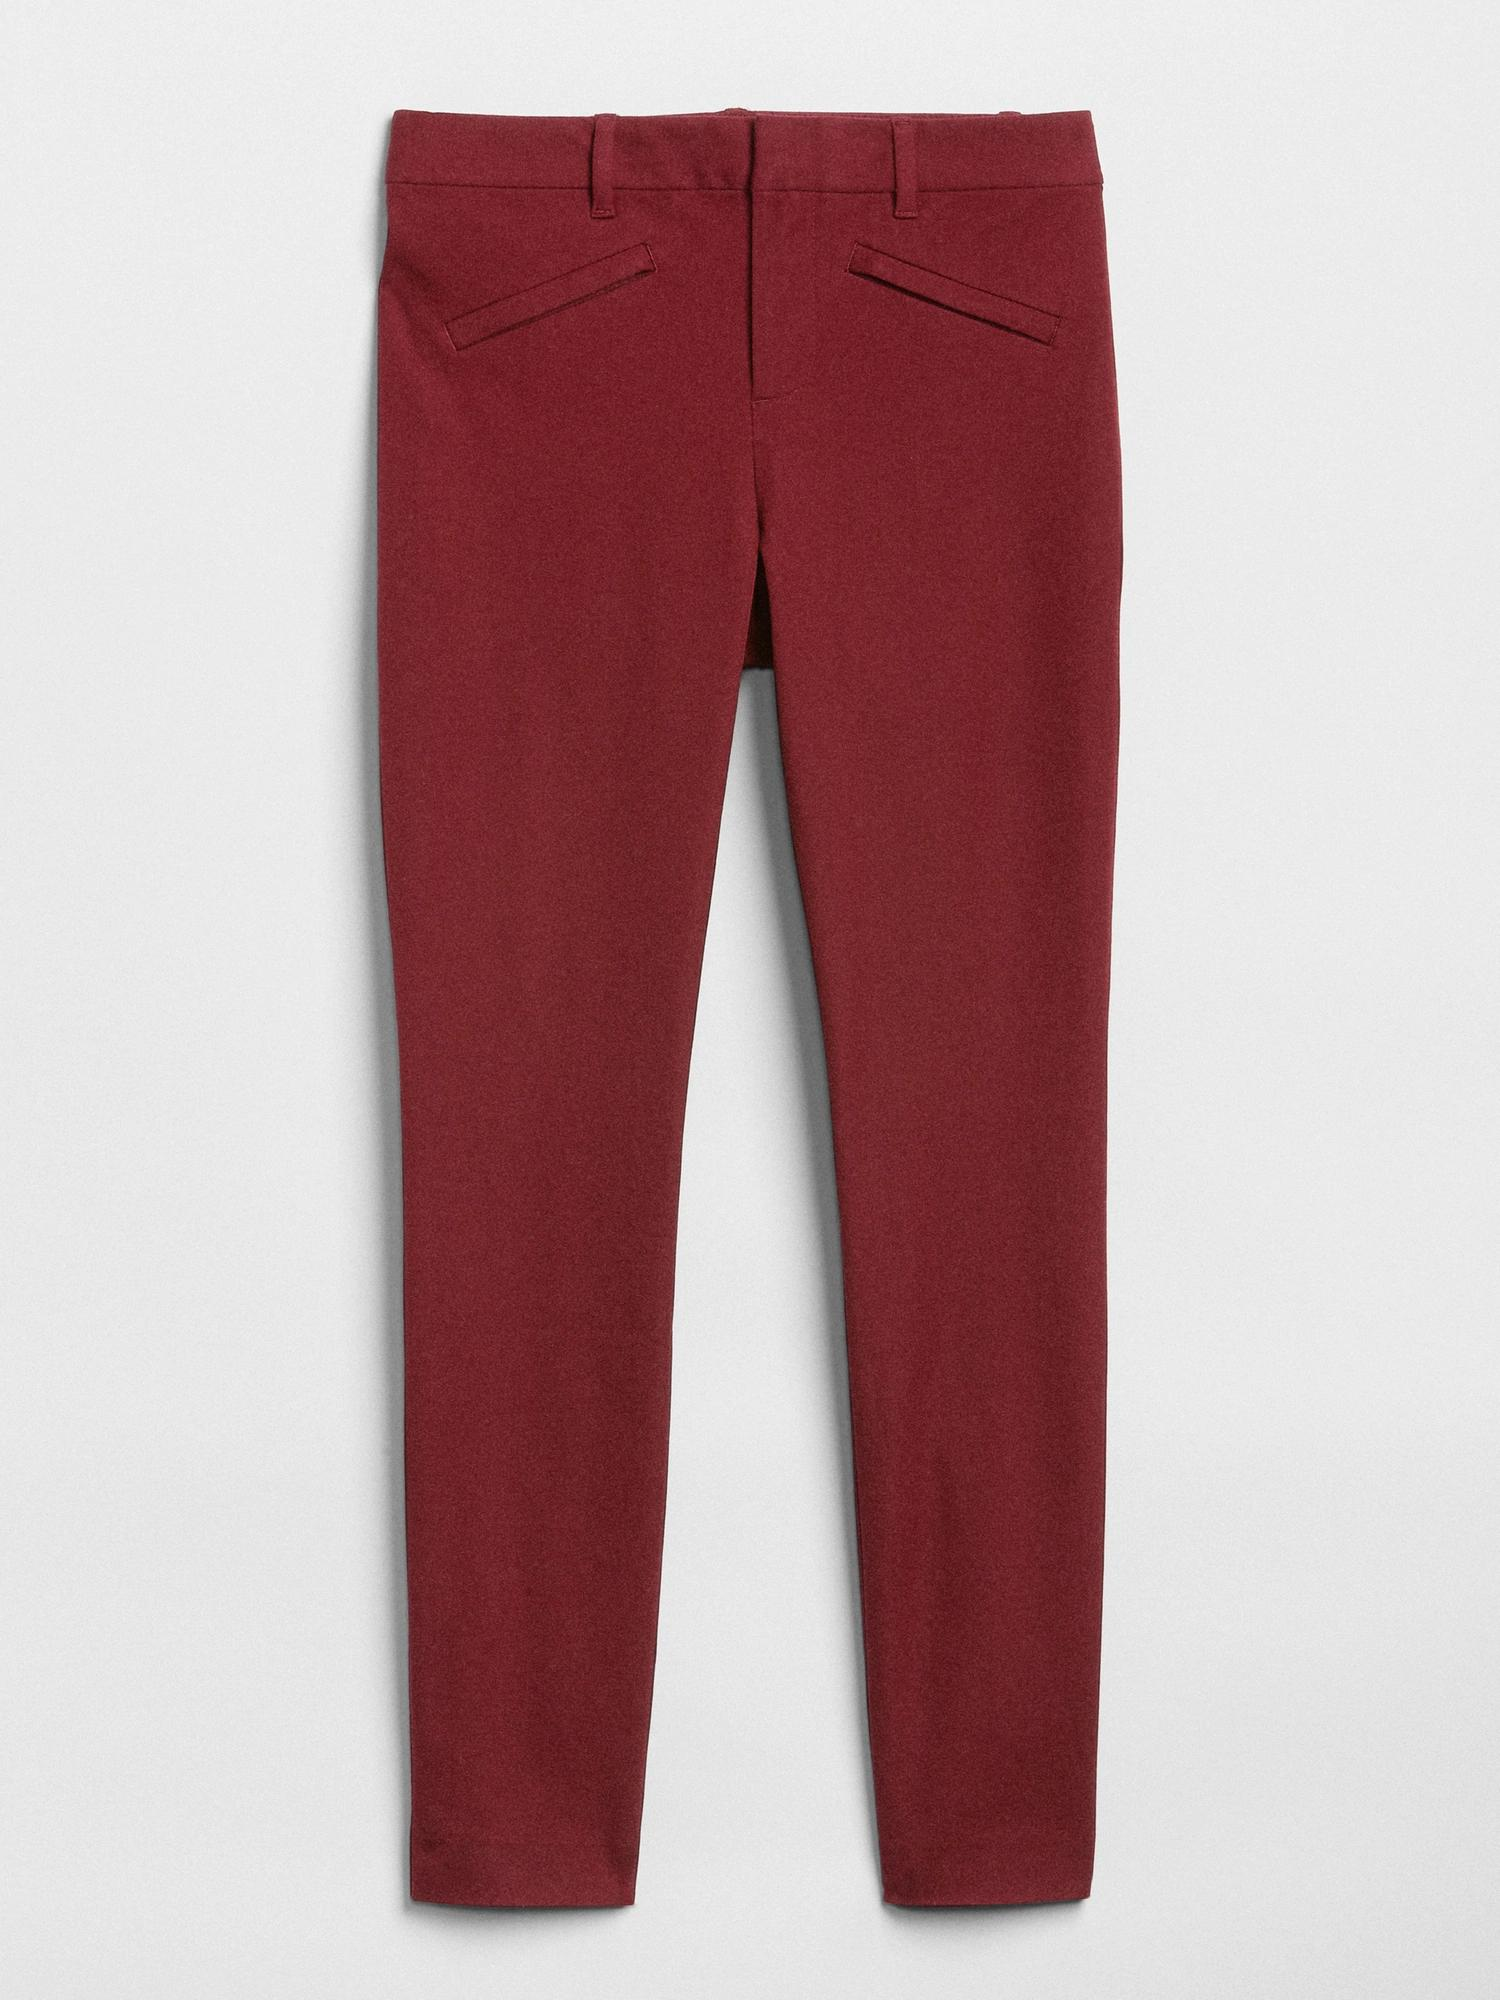

In [243]:
from IPython.display import Image
Image(im_path, width=400, height=400)